<a href="https://colab.research.google.com/github/bth0114/AIFFEL_DLThon_DKTC_online13/blob/main/notebooks/jiwoong/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy

## 모듈 불러오기 및 파일 경로 지정

In [2]:
import os
import re
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import F1Score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input

In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC_online13
current_dir = os.getcwd()
csv_dir = os.path.join(current_dir, 'data', 'raw_csv')
train_csv_path = os.path.join(csv_dir, 'merged_train.csv')

/content/drive/MyDrive/Colab Notebooks/Aiffel/AIFFEL_DLThon_DKTC_online13


## 데이터 전처리
- 구두점 제거
- 명사, 동사, 형용사, 부사, 숫자를 기준으로 토큰화
- 최대 길이를 기준으로 패딩

In [4]:
INPUT_MAX_LENGTH = 350  # 입력 시퀀스 최대 길이
NUM_WORDS = 7000 # 토큰화에 사용할 단어 갯수
EMBEDDING_DIM = 64  # 임베딩 차원

In [5]:
df = pd.read_csv(train_csv_path)
ordered_columns = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화'] # kaggle에 명시된 순서로 재배치

conversations = df['conversation'].to_list() # input
labels = pd.get_dummies(df['class'])
labels = labels[ordered_columns].to_numpy() # target

In [6]:
# 훈련셋,검증셋 분리
X_train_raw, X_val_raw, y_train, y_val = train_test_split(conversations, labels, test_size=0.2, stratify=labels, random_state=42)

In [7]:
# 구두점을 제거하는 함수
def remove_punctuation(texts):
    result = []
    for text in texts:
        # ?! 제외한 모든 특수문자 제거
        text = re.sub(r'[^\w\s?!]', '', text.replace('\n', ' '))
        result.append(text)
    return result

# 명사, 동사, 형용사, 부사, 숫자를 기준으로 토큰화해주는 함수
def pos_tagging(texts):
    okt = Okt()

    result = []
    for text in texts:
        filtered_words = [word for word, pos in okt.pos(text) if pos in [
            'Noun', 'Verb', 'Adjective', 'Adverb',  # 기본 품사
            'Number'                                # 금전 관련 숫자 정보
        ]]
        result.append(filtered_words)  # 각 문장별로 필터링된 단어들을 리스트로 저장

    return result

# 토크나이저 생성 함수
def create_tokenizer(texts, num_words=None): # num_words = 인코딩 시 사용할 단어 개수
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts) # 어휘사전 정의

    return tokenizer

# 모든 전처리 함수. 구두점 제거, 품사기준 토큰화, 정수 인코딩, 패딩
def preprocessing(texts, tokenizer, padded_max_len):
  removed_punctuation_texts = remove_punctuation(texts)
  pos_tagged_texts = pos_tagging(removed_punctuation_texts)
  sequences = tokenizer.texts_to_sequences(pos_tagged_texts)
  padded_sequences = pad_sequences(sequences, maxlen=padded_max_len)

  return padded_sequences

In [8]:
# 토크나이저 생성
tokenizer = create_tokenizer(conversations, NUM_WORDS)
print("생성된 어휘 수:", len(tokenizer.word_index))

생성된 어휘 수: 55065


In [9]:
# 전처리 수행
X_train = preprocessing(X_train_raw, tokenizer, INPUT_MAX_LENGTH)
X_val = preprocessing(X_val_raw, tokenizer, INPUT_MAX_LENGTH)

## 모델 훈련
- 1개의 양방향 LSTM과 드롭아웃 층으로 구성
- F1score를 기준으로 조기종료 수행

In [10]:
vocab_size = NUM_WORDS + 1  # 패딩

inputs = Input(shape=(INPUT_MAX_LENGTH,))
embedding = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM)(inputs)
lstm = Bidirectional(LSTM(64))(embedding)
dropout = Dropout(0.5)(lstm)
outputs = Dense(5, activation='softmax')(dropout)
model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 350)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 350, 64)        │       448,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514,757 (1.96 MB)

 Trainable params: 514,757 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# F1Score 메트릭 생성 (클래스 수에 맞게 설정)
f1 = F1Score(average='macro', name='f1')  # 명시적 이름 설정

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1])

In [12]:
es_callback = EarlyStopping(
    monitor='val_f1',
    patience=3,
    restore_best_weights=True,
    mode='max'
)

mc_callback = ModelCheckpoint(
    './notebooks/jiwoong/models/baseline.keras',
    monitor="val_f1",
    save_best_only=True,
    mode="max",
)

history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[es_callback, mc_callback]
)

Epoch 1/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.2905 - f1: 0.2404 - loss: 1.5223 - val_accuracy: 0.6272 - val_f1: 0.6356 - val_loss: 1.0610
Epoch 2/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.6471 - f1: 0.6460 - loss: 0.9135 - val_accuracy: 0.7144 - val_f1: 0.7181 - val_loss: 0.7109
Epoch 3/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8138 - f1: 0.8128 - loss: 0.5494 - val_accuracy: 0.7856 - val_f1: 0.7843 - val_loss: 0.5938
Epoch 4/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8810 - f1: 0.8818 - loss: 0.3908 - val_accuracy: 0.8147 - val_f1: 0.8152 - val_loss: 0.5612
Epoch 5/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9150 - f1: 0.9182 - loss: 0.2861 - val_accuracy: 0.8394 - val_f1: 0.8437 - val_loss: 0.5119
Epoch 6/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9613 - f1: 0.9627 - loss: 0.1628 - val_accuracy: 0.8664 - val_f1: 0.8701 - val_loss: 0.4354
Epoch 7/40
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 2

## 결과 분석

In [13]:
# 그래프를 출력하는 함수
def plot_training_history(history):
    history_dict = history.history
    epochs = range(1, len(history_dict['loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_dict['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history_dict['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # F1Score plot
    if 'f1' in history_dict and 'val_f1' in history_dict:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history_dict['f1'], 'bo-', label='Training F1')
        plt.plot(epochs, history_dict['val_f1'], 'ro-', label='Validation F1')
        plt.title('Training and Validation F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()

    plt.tight_layout()
    plt.show()

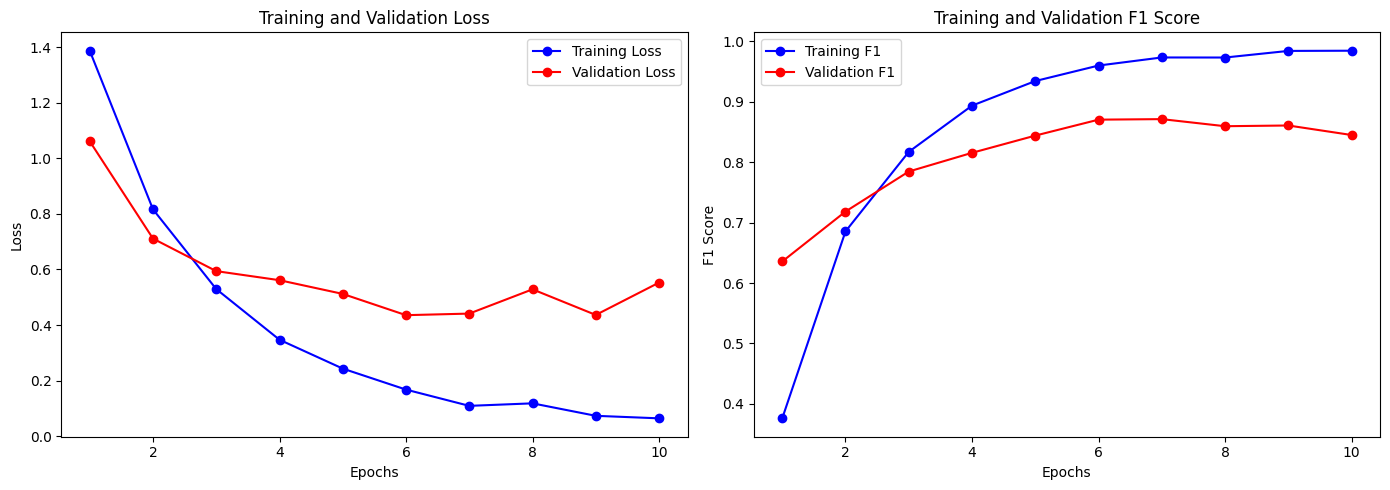

In [14]:
plot_training_history(history)

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_val, axis=1)

print(confusion_matrix(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=ordered_columns))

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
[[140  11   3  25   0]
 [ 12 160   7  16   0]
 [  2   0 179  13   0]
 [ 13   9   9 171   0]
 [  0   0   4   0 154]]
              precision    recall  f1-score   support

       협박 대화       0.84      0.78      0.81       179
       갈취 대화       0.89      0.82      0.85       195
 직장 내 괴롭힘 대화       0.89      0.92      0.90       194
   기타 괴롭힘 대화       0.76      0.85      0.80       202
       일반 대화       1.00      0.97      0.99       158

    accuracy                           0.87       928
   macro avg       0.87      0.87      0.87       928
weighted avg       0.87      0.87      0.87       928



+ 데이터 EDA 때 예상한 대로 일반대화에 많이 과적합되었으며 직장 내 괴롭힘 대화는 점수가 높음
+ 나머지 세 카테고리에 대해서는 아쉬운 성능

## submission

In [16]:
test_csv_path = os.path.join(csv_dir, 'test.csv')

df_test = pd.read_csv(test_csv_path)
conversations_test = df_test['text'].to_list()

X_text = preprocessing(conversations_test, tokenizer, INPUT_MAX_LENGTH)

In [17]:
# 모델 예측 (Softmax를 사용하여 각 클래스에 대한 확률 계산)
predictions = model.predict(X_text)

# 예측 결과를 클래스 인덱스로 변환
predicted_classes = predictions.argmax(axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [18]:
# id와 예측된 클래스 저장
submission_df = pd.DataFrame({
    'idx': df_test['idx'],
    'class': predicted_classes
})

display(submission_df)

# submission.csv로 저장
submission_df.to_csv('/content/submission.csv', index=False)

,idx,class
0,t_000,0
1,t_001,2
2,t_002,2
3,t_003,2
4,t_004,3
...,...,...
495,t_495,2
496,t_496,1
497,t_497,1
498,t_498,0


## 제출 결과

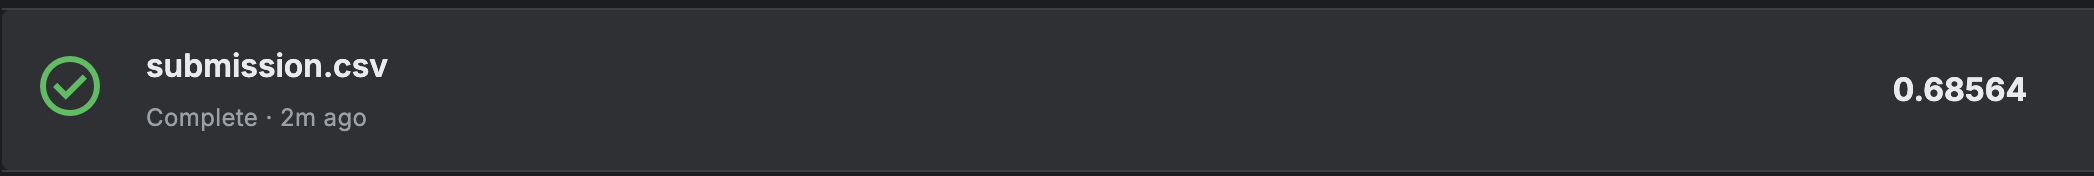